# **Разведочный анализ данных (Explanatory Data Analysis = EDA) в Python**

In [104]:
# импорт всех необходимых библиотек
import re
import os
import itertools
import cftime
import pandas as pd
import xarray as xr
import numpy as np
import multiprocessing as mp
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy.ma as ma
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.cm as cm
import seaborn as sns
from matplotlib import pyplot as plt
from netCDF4 import Dataset

# Загрузка, чтение и подготовка данных
Используются данные климатической модели ИВМ РАН версии INM-CM6P в формате NetCDF по <u>среднемесячным</u> полям - **температуре поверхности океана (ТПО), температуре воздуха на 2 м (Т2) и давлению на уровне моря (ДУМ)** по всему земному шару. *Шаг модели - 1.5 градуса от 90 градусов ю.ш. до 90 градусов с.ш. и 2 градуса от 180 градусов з.д. до 180 градусов в.д.*

In [129]:
path = 'C:/Users/1/Videos/INMCM6P_data/historical'
file1 = 'SST_1960_2024.nc'
dataset1 = xr.open_dataset(os.path.join(path,file1))
dataset1['SST'] = dataset1['SST'] - 273.15 # переводим значения ТПО из градусов Кельвина в градусы Цельсия
df1 = dataset1.isel(time=slice(0, 660), lat=slice(70, 71), lon=slice(60, 61)).to_dataframe().reset_index() # вырезаем период 1960-2014 гг.
# и 1 точку по пространству в районе ЭНЮК
file2 = 'PS_1960_2024.nc' 
dataset2 = xr.open_dataset(os.path.join(path, file2))['PS']
df2 = dataset2.isel(time=slice(0, 660), lat=slice(70, 71), lon=slice(60, 61)).to_dataframe().reset_index() # вырезаем период 1960-2014 гг.
file3 = 'T2_1960_2024.nc' 
dataset3 = xr.open_dataset(os.path.join(path, file3))
dataset3['T2'] = dataset3['T2'] - 273.15 # переводим значения T2 из градусов Кельвина в градусы Цельсия
df3 = dataset3.isel(time=slice(0, 660), lat=slice(70, 71), lon=slice(60, 61)).to_dataframe().reset_index() # вырезаем период 1960-2014 гг.
dataframe = df1[['time', 'lat', 'lon', 'SST']].copy()
dataframe['PS'] = df2['PS'] 
dataframe['T2'] = df3['T2'] 
dataframe['time'] = dataframe['time'].dt.strftime('%Y-%m') # переходим в более компактный формат записи времени
dataframe['time'] = pd.to_datetime(dataframe['time'])
dataframe = dataframe.set_index('time')
display(dataframe) 

,lat,lon,SST,PS,T2
time,,,,,
1960-01-01,15.75,-60.0,24.563684,1016.594604,22.784052
1960-02-01,15.75,-60.0,23.691187,1017.168457,22.297662
1960-03-01,15.75,-60.0,23.696558,1015.526978,22.015161
1960-04-01,15.75,-60.0,24.496667,1014.915100,23.617761
1960-05-01,15.75,-60.0,24.893915,1015.490417,24.117120
...,...,...,...,...,...
2014-08-01,15.75,-60.0,26.332025,1015.648438,25.601251
2014-09-01,15.75,-60.0,26.847253,1014.681458,26.263116
2014-10-01,15.75,-60.0,26.596277,1015.254700,25.471887


*Имеем данные по <u>среднемесячных</u> **ТПО, Т2 и ДУМ** для периода января 1960 г. - декабря 2014 г. для точки с коррдинатами 15.75 градусов с.ш., 60 градусов з.д., расположенной в области распространения ЭНЮК*

## Изучение типа данных

In [130]:
display(dataframe.info())
dataframe = dataframe.apply(pd.to_numeric, errors='coerce') # преобразуем текстовые значения в числовые
display(dataframe.info())
dataframe.to_csv('C:/Users/1/Videos/INMCM6P_data/SST_1960_2024.csv') # сохраняем результаты в csv-файл

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 660 entries, 1960-01-01 to 2014-12-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     660 non-null    float32
 1   lon     660 non-null    float32
 2   SST     660 non-null    float64
 3   PS      660 non-null    float64
 4   T2      660 non-null    float64
dtypes: float32(2), float64(3)
memory usage: 25.8 KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 660 entries, 1960-01-01 to 2014-12-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     660 non-null    float32
 1   lon     660 non-null    float32
 2   SST     660 non-null    float64
 3   PS      660 non-null    float64
 4   T2      660 non-null    float64
dtypes: float32(2), float64(3)
memory usage: 25.8 KB


None

*Широта, долгота, ТПО, Т2 и ДУМ записаны в формате чисел с плавающей запятой. Для широты и долготы используется 32 бита, для метеополей - 64 бита памяти. Всего у нас 660 временных срезов для каждой метеовеличины*

### Визуализация временных рядов
Посмотрим на ход ТПО, Т2 и ДУМ в условиях сильного ЭНЮК (фаза Эль-Ниньо), охватывающего период мая 1997 - июня 1998 гг. для выбранной точки пространства

<Figure size 640x480 with 0 Axes>

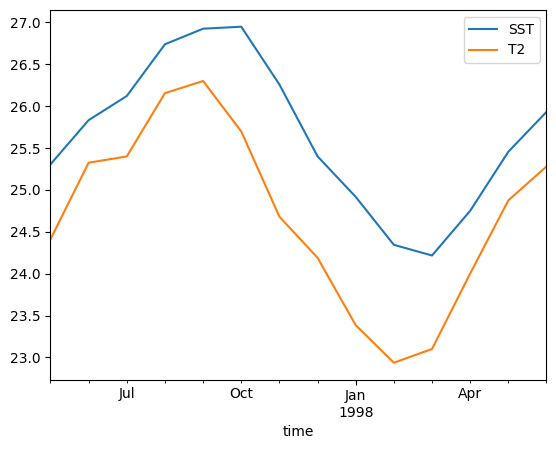

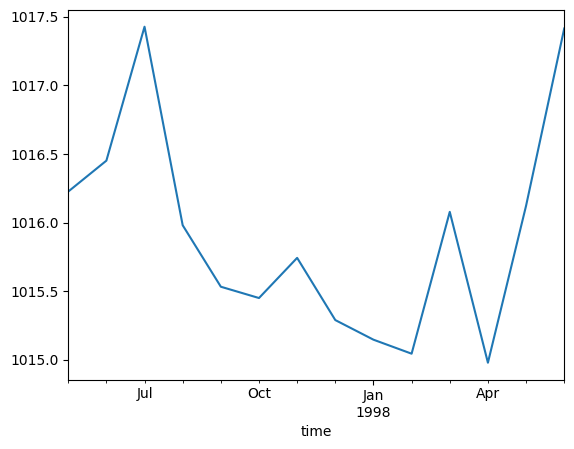

In [132]:
%matplotlib inline 
plt.figure()
dataframe['1997-05':'1998-06'][['SST', 'T2']].plot()
plt.show()
plt.figure()
dataframe['1997-05':'1998-06']['PS'].plot()
plt.show()

*Временной ход ТПО и Т2, как и следовало ожидать, хорошо согласуется между собой. В рассматриваемый период наиболее высокое значени Т2 фиксировалось в сентябре 1997 г. (27 градусов Цельсия), минимальное - в феврале 1998 г. (22 градуса Цельсия). Для ТПО отмечалось некоторое "запаздывание" - она достигала минимальной отметки в марте 1998 г. (23 градуса Цельсия) и максимальной в октябре 1997 г. (27 градусов Цельсия). Максимум давления пришелся на июль 1997 г. (1018 гПа), минимум - на апрель 1998 г. (1014 гПа)*

### Анализ доступности данных

,lat,lon,SST,PS,T2
time,,,,,
1960-01-01,False,False,False,False,False
1960-02-01,False,False,False,False,False
1960-03-01,False,False,False,False,False
1960-04-01,False,False,False,False,False
1960-05-01,False,False,False,False,False
...,...,...,...,...,...
2014-08-01,False,False,False,False,False
2014-09-01,False,False,False,False,False
2014-10-01,False,False,False,False,False


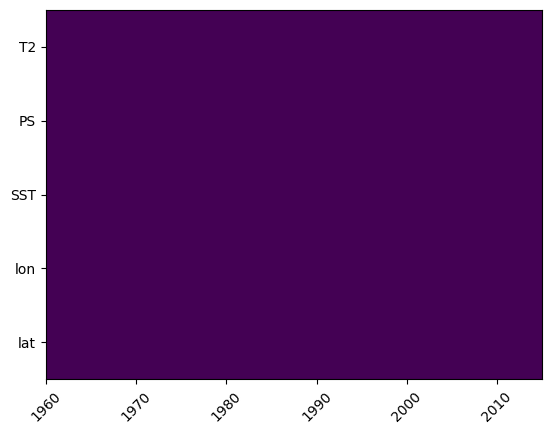

In [133]:
data_missing = dataframe.isnull() 
display(data_missing)
plt.pcolormesh(data_missing.index, data_missing.columns, data_missing.T.to_numpy())
_ = plt.xticks(rotation=45)

*Можно сделать вывод, что в рассматриваемом массиве данных **нет** отсутствующих значений ни для одного из исследуемых метеопараметров*

# Одномерный разведочный анализ данных (univariate analysis)

## Анализ статистических моментов

In [134]:
dataframe.describe().T #Транспонирование

,count,mean,std,min,25%,50%,75%,max
lat,660.0,15.750000,0.000000,15.750000,15.750000,15.750000,15.750000,15.750000
lon,660.0,-60.000000,0.000000,-60.000000,-60.000000,-60.000000,-60.000000,-60.000000
SST,660.0,25.349810,1.007615,23.072046,24.476884,25.412607,26.219469,27.398035
PS,660.0,1016.028740,0.761587,1013.616638,1015.524765,1016.066742,1016.604980,1018.224487
T2,660.0,24.346192,1.178684,21.541772,23.335901,24.432993,25.341928,26.862085


*В таблице представлены минимальные и максимальные значений каждого из исследуемых метеопараметров (уже были описаны выше), 25, 75 и 50 (медиана) процентили (будут приведены ниже), а также среднее значение и стандартное отклонение. Наименьшее стандартное отклонение отмечается для давления*

## Анализ уникальных значений

Уникальные значения в столбцах: 


lat                                              [15.75]
lon                                              [-60.0]
SST    [24.563684082031273, 23.691186523437523, 23.69...
PS     [1016.5946044921875, 1017.16845703125, 1015.52...
T2     [22.784051513671898, 22.297662353515648, 22.01...
dtype: object

Число уникальных значений в столбцах:  


lat      1
lon      1
SST    658
PS     657
T2     659
dtype: int64

SST        PS           T2       
23.072046  1016.464478  21.541772    1
23.172662  1016.537109  21.694238    1
23.251001  1016.871216  22.264459    1
23.281854  1015.044861  22.322565    1
23.286218  1016.335571  21.709283    1
                                    ..
27.223474  1015.221985  26.412317    1
27.258417  1014.859497  26.122766    1
27.310632  1015.471252  26.748041    1
27.378168  1014.522461  26.862085    1
27.398035  1015.135559  26.519800    1
Name: count, Length: 660, dtype: int64

<Axes: ylabel='count'>

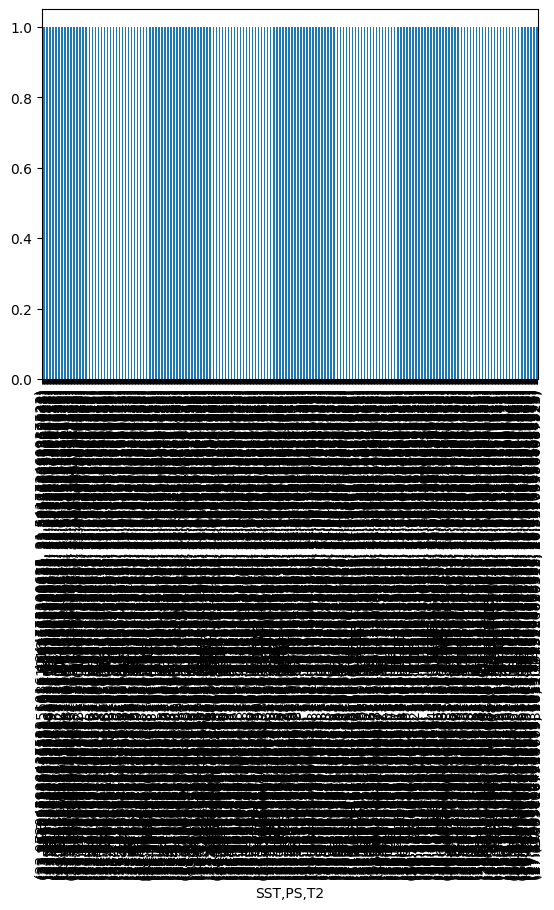

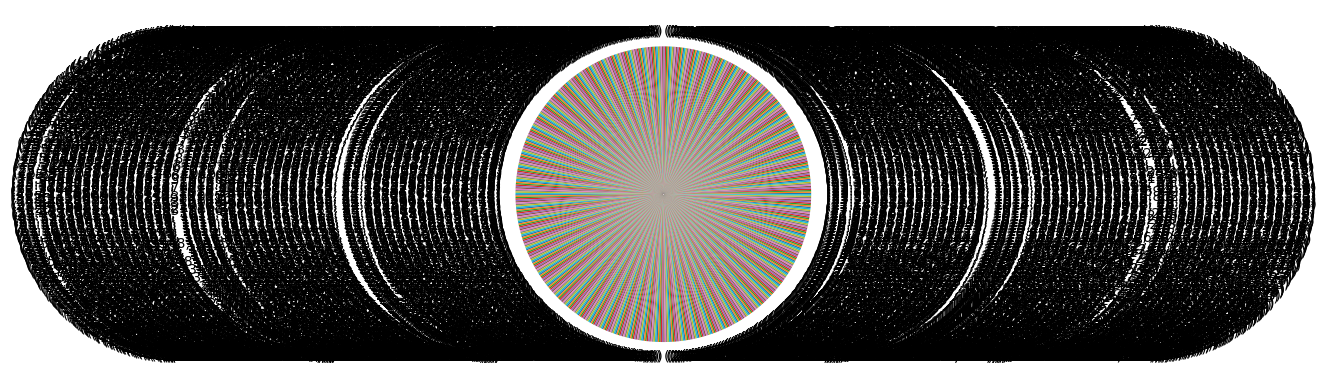

In [148]:
nunique = lambda x: len (pd.unique(x))
print ('Уникальные значения в столбцах: ')
display(dataframe.apply (pd.unique))
print ('Число уникальных значений в столбцах:  ')
display(dataframe.nunique()) # выводим уникальные значения для каждого признака
display(dataframe[['SST','PS','T2']].value_counts().sort_index())
plt.figure()
dataframe[['SST','PS','T2']].value_counts().sort_index().plot.bar() #
plt.figure()
dataframe[['SST','PS','T2']].value_counts().sort_index().plot.pie() #

*Число "уникальных" значений ТПО за весь рассматриваемый период составляет 658. С учетом того, что весь рассматриваемый период охватывает 660 временных "срезов", можно сказать, что значения ТПО в рассматриваемой точке за всё время повторились дважды. Для ДУМ число уникальных случаев составляет 657, т.е. наблюдалось 3 повтора значений, тогда как для Т2 их число минимально - 1*

## Анализ функций распределения

array([[<Axes: title={'center': 'SST'}>, <Axes: title={'center': 'PS'}>],
       [<Axes: title={'center': 'T2'}>, <Axes: >]], dtype=object)

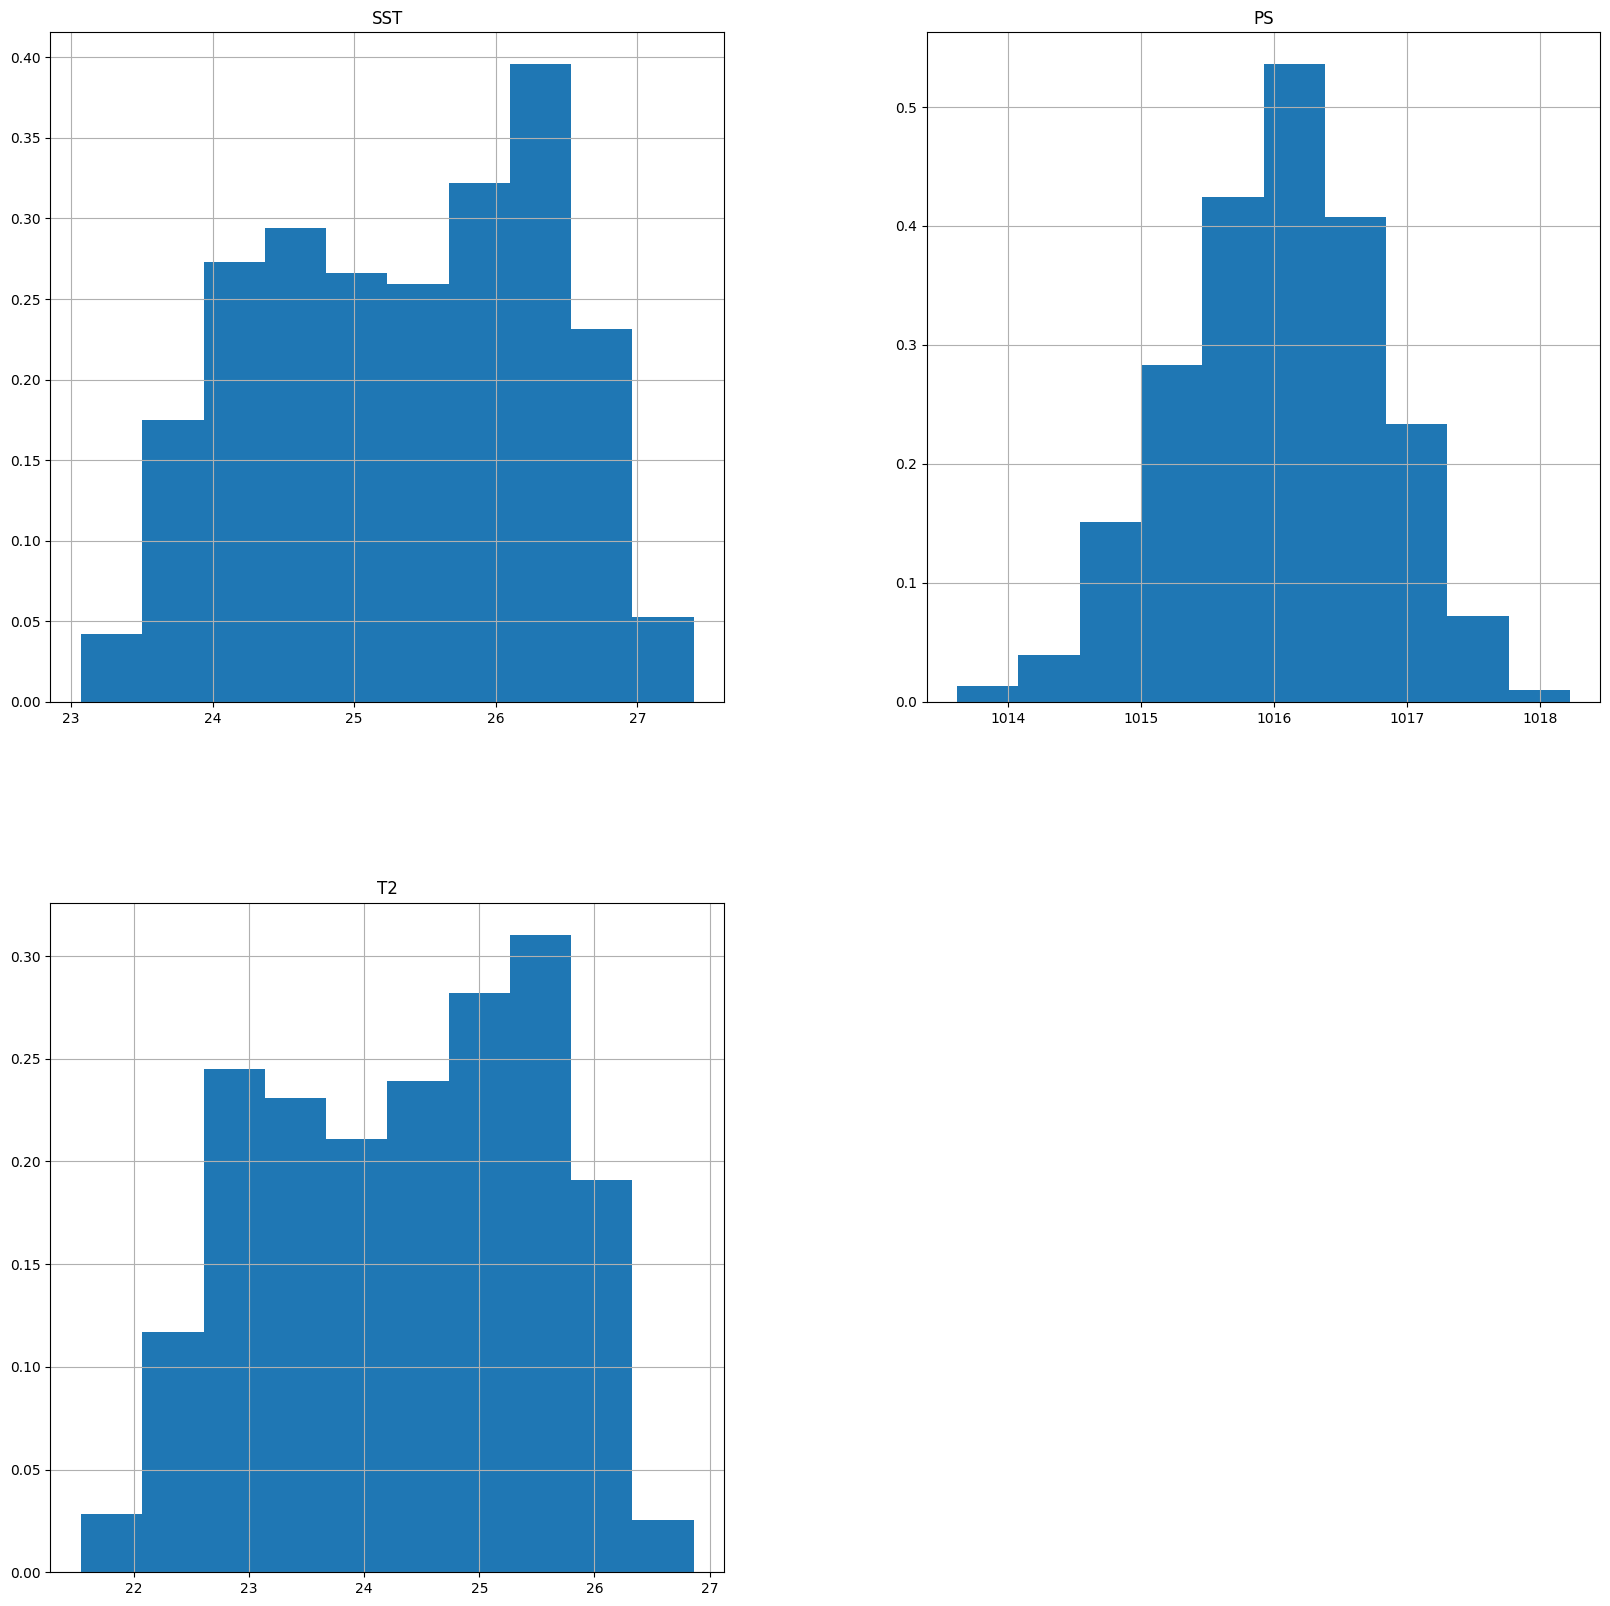

In [136]:
%matplotlib inline
dataframe[['SST','PS','T2']].hist(figsize=(20,20), density=True)

*Стоит отметить, что функция распределения вероятности для ТПО и Т2 имеет достаточно интересный вид - четко прослеживаются два "пика". Тем не менее, если "сглаживать" полученный график, то уместее было бы сказать, что функция для ТПО соответствует нормальному распределению. Распределение для ДУМ четко можно отнести к нормальному*

## Графики ядерной плотности (kernel density plots)

C:\Users\1\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


(0.0, 40.0)

<Figure size 640x480 with 0 Axes>

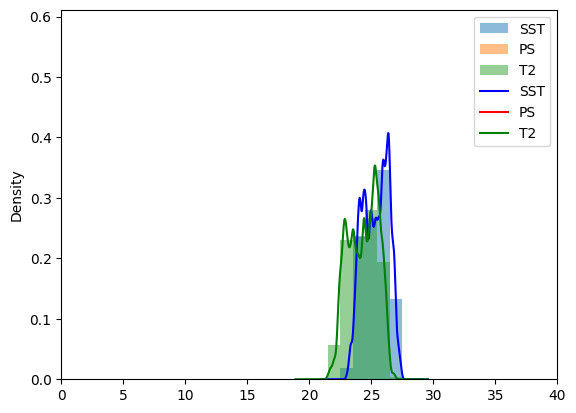

In [141]:
# Гистограммы и графики ядерной плотности 
plt.figure()
dataframe[['SST','PS','T2']].plot.hist(alpha=0.5, density = True, bins=np.arange(-0.5, 40.5))
dataframe[['SST','PS','T2']].plot.density(ax = plt.gca(), color = ['blue', 'red', 'green'], bw_method=0.1) 
plt.xlim(0, 40)

*Получаем графики с 2 уже отмеченными раннее пиками*

## Идентификация выбросов

<Axes: >

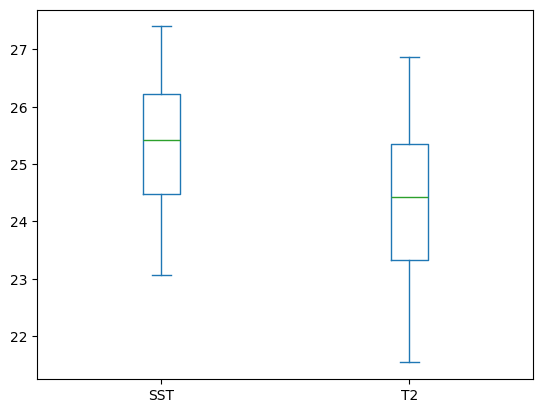

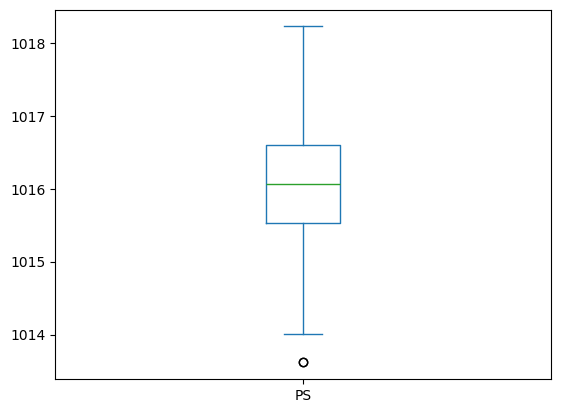

In [144]:
dataframe[['SST','T2']].plot.box() # ящик с усами
dataframe[['PS']].plot.box() # ящик с усами

*Имеем диаграммы размаха: для ТПО - 25, 50 (медиана) и 75 процентили составляют 24, 25 и 26 градусов Цельсия. Для Т2 - процентили 23, 24 и 25 градусов Цельсия соответственно. Для ДУМ - 1015.5, 1016 и 1016.6 гПа. Для давления наблюдается интересный "выброс" - это минимальное для всего рассматриваемого периода давление, причем оно наблюдалось ближе к концу фазы наиболее активного ЭНЮК*

# Двумерный анализ данных (bivariate data analysis)

,lat,lon,SST,PS,T2
lat,NaN,NaN,NaN,NaN,NaN
lon,NaN,NaN,NaN,NaN,NaN
SST,NaN,NaN,1.000000,-0.361887,0.964434
PS,NaN,NaN,-0.361887,1.000000,-0.325783
T2,NaN,NaN,0.964434,-0.325783,1.000000


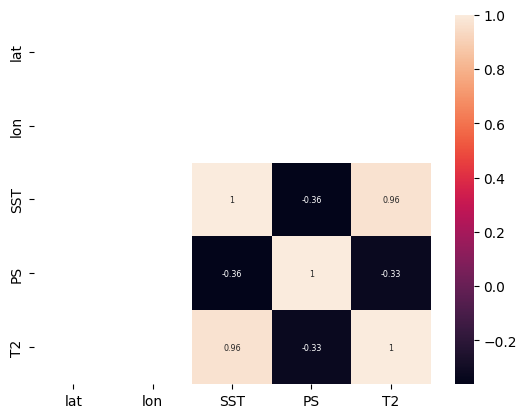

In [146]:
corrs = dataframe.corr() # диаграмма корреляции
display (corrs)
s = sns.heatmap (corrs, annot=True, annot_kws={'fontsize': 'xx-small'})
#plt.set(s,  fontsize = 'x-small')

*В рассматриваемом случае данный график не является слишком информативным, поскольку рассматриваются только 3 метеовеличины. Как и следовало ожидать, высокие коэффициенты корреляции отмечаются между значениями ТПО и Т2. Для ДУМ и температур коэффициент корреляции достаточно невелик и по модулю не превышает 0.4*

(np.float64(21.27575683593752), np.float64(27.128100585937524))

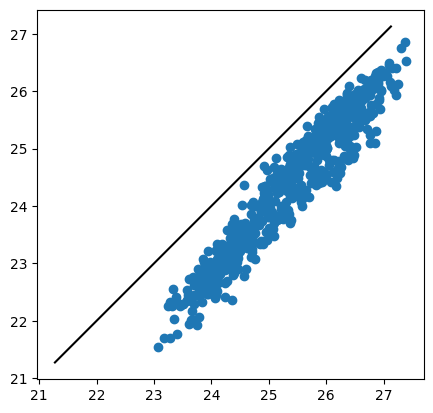

In [158]:
plt.figure() # диаграммы рассеяния
plt.scatter (dataframe['SST'], dataframe['T2'])
y_lim = plt.ylim()
display(y_lim)
plt.plot(y_lim, y_lim, '-k')
plt.gca().set_aspect('equal')

*По диаграмме рассеяния видно, что значения практически ложатся на диагональ, что также подтверждает ранее сделанный вывод о сильной взаимосвязи между переменными температуры воздуха и поверхности* 

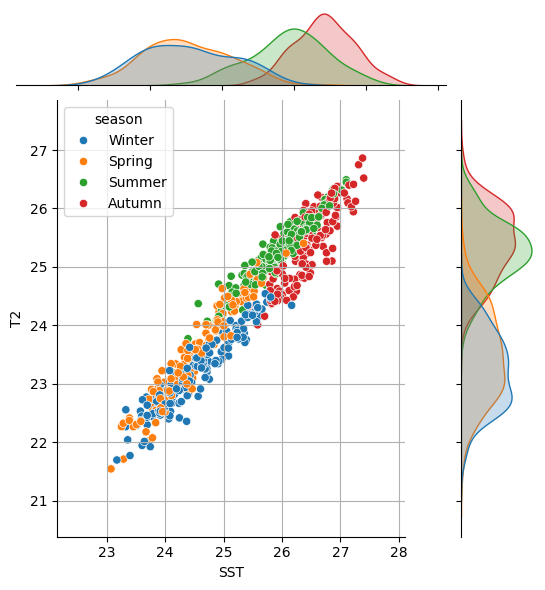

In [166]:
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'


df['season'] = [month_to_season (m) for m in dataframe.index.month] 

sns.jointplot(dataframe, x = 'SST', y = 'T2', hue = 'season', palette="tab10") #, kind = 'hex', color = 'blue') palette="tab10") #
plt.gca().set_aspect('equal')
plt.grid()

*Можно отметить, что распределение температуры имеет схожий характер в период зимы и весны, а также осени и лета. Вновь хорошо прослеживается высокая степень взаимосвязанности между температурой воздуха на 2 м и поверхности*

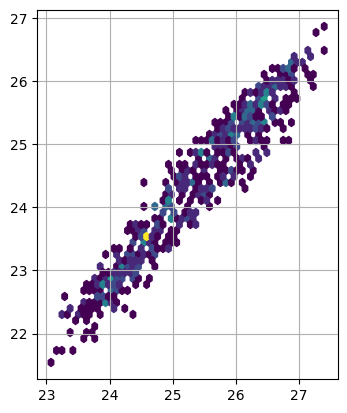

In [168]:
plt.hexbin(dataframe['SST'], dataframe['T2'], gridsize=50, mincnt = 1) # шестиугольные корзины
plt.gca().set_aspect('equal')
plt.grid()
# plt.xlim((0, 50))
# plt.ylim((0, 50))

*Отмечается сильная cвязь между 2 параметрами температуры*

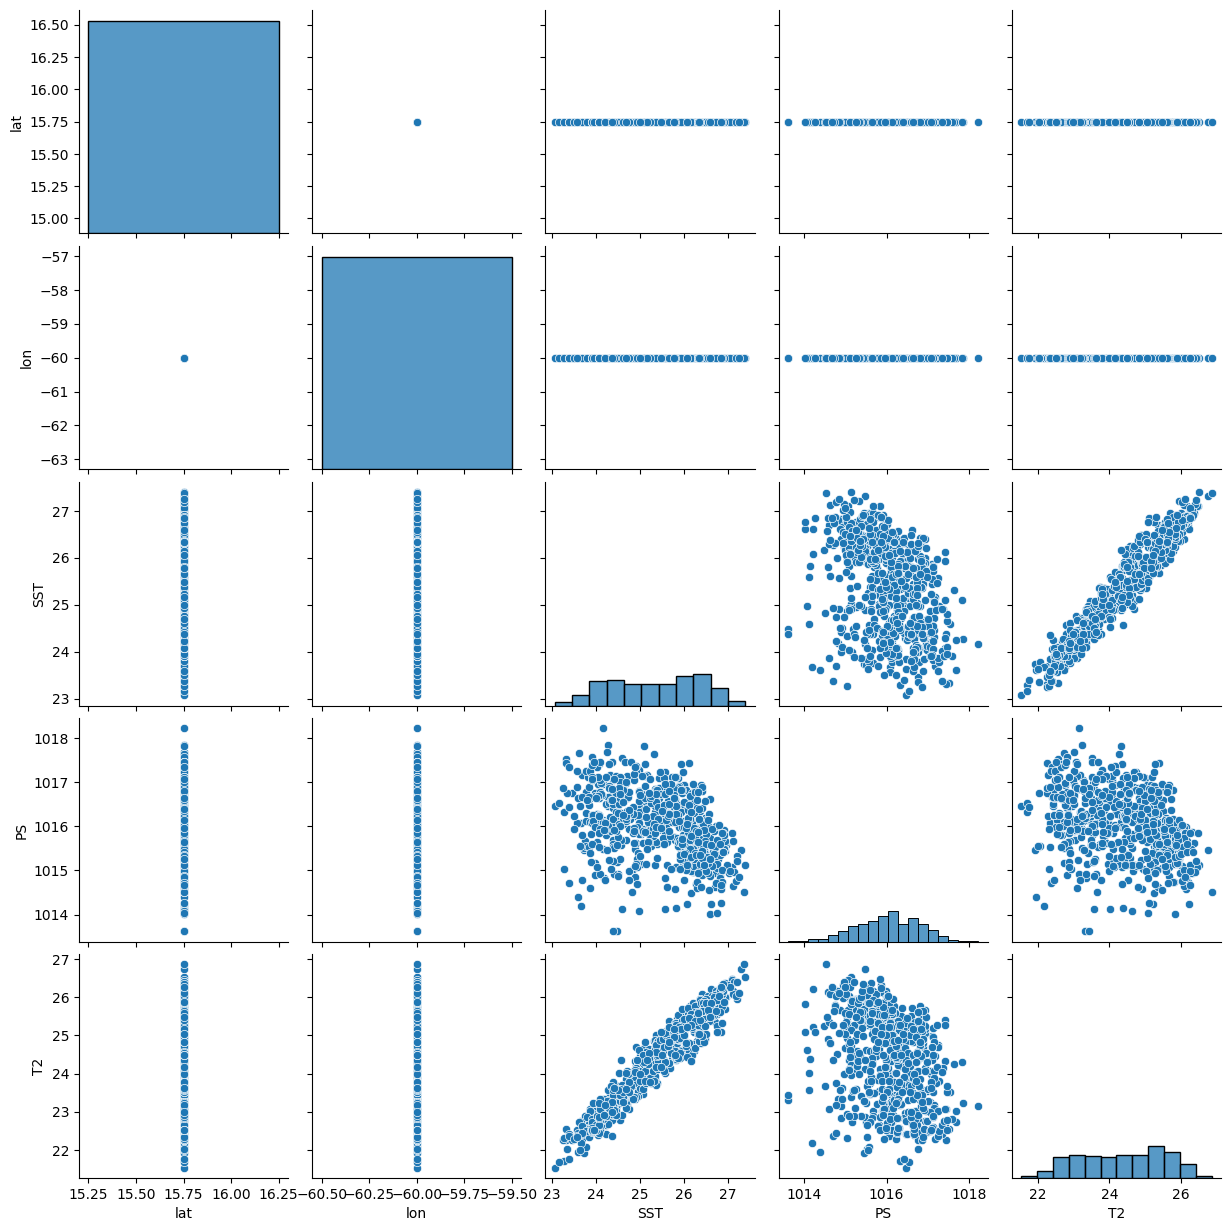

In [170]:
sns.pairplot (dataframe)

*Хорошо проявляется прочная взаимосвязь между 2 температурами, тогда как температуры и давление согласуются слабо*

# Многомерный анализ данных

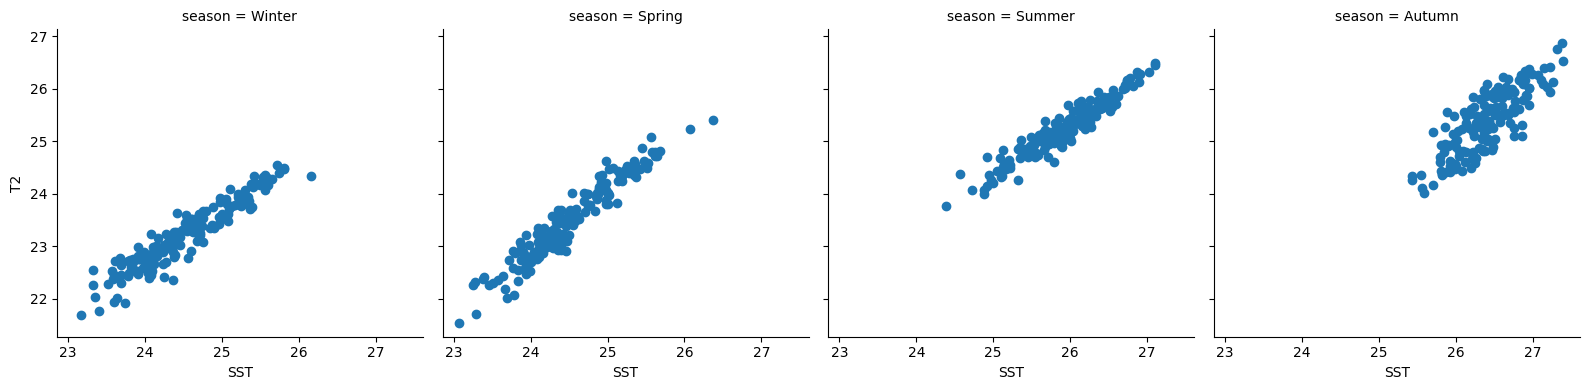

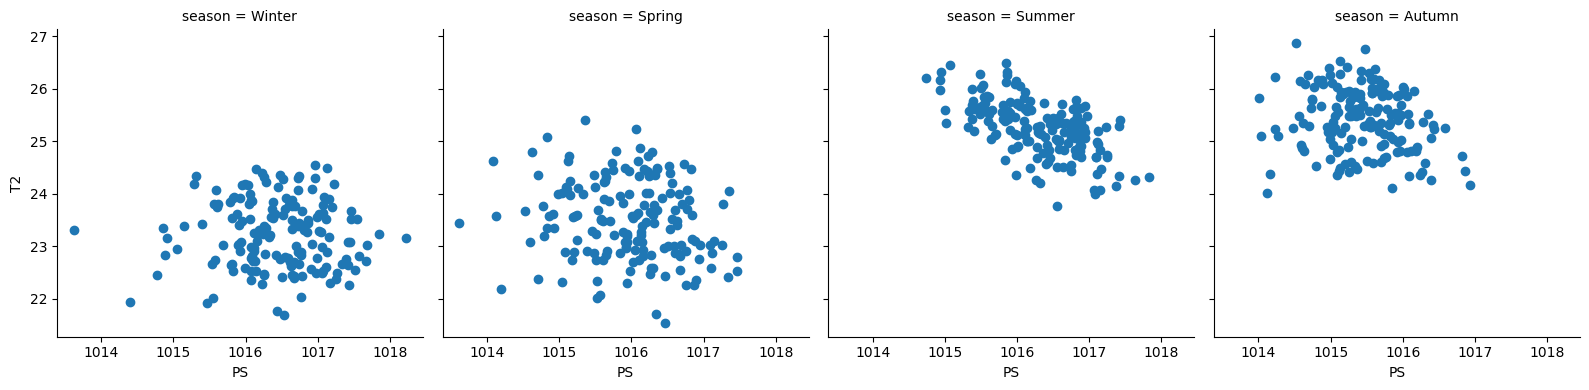

In [174]:
g = sns.FacetGrid(dataframe, col = 'season', height=4, aspect = 1)  
g.map(plt.scatter, 'SST', 'T2') #, gridsize=20, mincnt = 1)
g = sns.FacetGrid(dataframe, col = 'season', height=4, aspect = 1)  
g.map(plt.scatter, 'PS', 'T2') #, gridsize=20, mincnt = 1)
g = sns.FacetGrid(dataframe, col = 'season', height=4, aspect = 1)  
g.map(plt.scatter, 'PS', 'T2') #, gridsize=20, mincnt = 1)

*Ниболее полное согласование между ТПО и Т2 - в летний период, аналогично между Т2 и ДУМ*